We already have code to look at the results of a simple AB test (50/50 split with two groups only). Let's visualize the results

We'll also want to extend the existing functions to handle different splits as well as different numbers of variants

In [22]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as mtick
import statsmodels.api as sm
from time import gmtime, strftime
from matplotlib import style

In [23]:
sys.path.append('../../ab_testing_utils/')

In [24]:
import conversion_rate_utils

In [52]:
from importlib import reload

In [249]:
import matplotlib as mpl

In [25]:
# set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [26]:
# set plot style
style.use('fivethirtyeight')

In [226]:
reload(conversion_rate_utils)

<module 'conversion_rate_utils' from '/Users/danielokeeffe/Documents/src/stats_utils/stats_utils/notebooks/scratch_work/../../ab_testing_utils/conversion_rate_utils.py'>

Generate some fake data

In [27]:
daily_num_observations = 10000
monthly_num_observations = daily_num_observations * 7 * 4
baseline_conversion_rate = 0.05
number_of_weeks_for_experiment = 2
number_of_days_for_experiment = number_of_weeks_for_experiment * 7

In [28]:
daily_units = []
day_list = []
for i in range(number_of_days_for_experiment):
    day_ = str(i)
    number_of_observations = np.random.poisson(daily_num_observations)
    observations = [1] * number_of_observations
    daily_units = daily_units + observations
    day_index = [day_] * number_of_observations
    day_list = day_list + day_index

In [29]:
df_ab = pd.DataFrame()
df_ab['day'] = day_list
df_ab['units'] = daily_units

In [30]:
# Now we need to do random assignment
def assign_randomly(df, p=0.5):
    df_ = df.copy()
    df_g = df_.groupby('day', as_index=False).sum()
    assignment = []
    for day_, num_obs in zip(df_g['day'].unique(), df_g['units'].unique()):
        assignments_ = np.random.binomial(n=1, p=0.5, size=num_obs)
        assignment = assignment + list(assignments_)
    df_['group'] = assignment
    df_['group'] = df_['group'].apply(lambda x: 'treatment' if x == 1 else 'control')
    
    return df_

In [31]:
df_ab = assign_randomly(df_ab)

In [32]:
def generate_conversions(df, control_p, treatment_p, treatment_name, group_col='group'):
    df_ = df.copy()
    conversions = []
    for n in df_[group_col].values:
        if n == treatment_name:
            p_ = treatment_p
        else:
            p_ = control_p
        conv_ = np.random.binomial(n=1, p=p_)
        conversions.append(conv_)
    
    df_['conversion'] = conversions
    
    return df_

In [33]:
df_ab = generate_conversions(df=df_ab, control_p=baseline_conversion_rate, treatment_p=baseline_conversion_rate + 0.1*baseline_conversion_rate, treatment_name='treatment')

In [34]:
# Let's run this manually and compare to the results of our code base

In [35]:
df_ab_results = df_ab[['group', 'units', 'conversion']].groupby('group', as_index=False).sum()

In [36]:
df_ab_results['conversion_rate'] = df_ab_results['conversion'] / df_ab_results['units']

In [206]:
# Is this a significant result?
z_score, p_value = sm.stats.proportions_ztest([df_ab_results.query("group=='treatment'")['conversion'].values, df_ab_results.query("group=='control'")['conversion'].values], 
                                              [df_ab_results.query("group=='treatment'")['units'].values, df_ab_results.query("group=='control'")['units'].values])

In [207]:
z_score

array([4.28414083])

In [208]:
p_value

array([1.83446695e-05])

In [209]:
lift = (df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] - df_ab_results.query("group=='control'")['conversion_rate'].iloc[0]) / df_ab_results.query("group=='control'")['conversion_rate'].iloc[0]

In [210]:
lift = lift * 100

In [211]:
lift

10.220871367098388

In [212]:
# We'll compute a 95% confidence interval as well. We'll treat this as a Bernoulli random variable. We could probably also bootstrap this
sigma_treated = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] * (1 - df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0])
treatment_sample_size = df_ab_results.query("group=='treatment'")['units'].iloc[0]

In [213]:
se_treated = np.sqrt(sigma_treated / treatment_sample_size)

In [214]:
treated_lower_ci_95 = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] - 1.96 * se_treated
treated_upper_ci_95 = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] + 1.96 * se_treated

In [215]:
# And for the control measurement:
sigma_control = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] * (1 - df_ab_results.query("group=='control'")['conversion_rate'].iloc[0])
control_sample_size = df_ab_results.query("group=='control'")['units'].iloc[0]
se_control = np.sqrt(sigma_control / control_sample_size)
control_lower_ci_95 = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] - 1.96 * se_control
control_upper_ci_95 = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] + 1.96 * se_control

In [216]:
df_ab_results['lower_ci_95'] = [control_lower_ci_95, treated_lower_ci_95]
df_ab_results['upper_ci_95'] = [control_upper_ci_95, treated_upper_ci_95]

In [217]:
df_ab_results

,group,units,conversion,conversion_rate,lower_ci_95,upper_ci_95
0,control,69750,3487,0.049993,0.048375,0.05161
1,treatment,70269,3872,0.055103,0.053415,0.05679


Ok now compare this with our code base

In [218]:
df_ab.head()

,day,units,group,conversion
0,0,1,treatment,0
1,0,1,control,0
2,0,1,treatment,0
3,0,1,treatment,0
4,0,1,control,0


In [227]:
exp = conversion_rate_utils.ConversionExperiment()

In [228]:
df_code_res = exp.simple_ab_test(df=df_ab, group_column_name='group', treatment_name='treatment', outcome_column='conversion', alpha=0.05, null_hypothesis=0)

In [229]:
df_code_res

,value
treatment_mean,0.055103
treatment_confidence_interval_95.0_percent_lower,0.053415
treatment_confidence_interval_95.0_percent_upper,0.056790
control_mean,0.049993
control_confidence_interval_95.0_percent_lower,0.048376
control_confidence_interval_95.0_percent_upper,0.051610
treatment_minus_control_mean,0.005110
treatment_minus_control_95.0_percent_lower,0.002773
treatment_minus_control_95.0_percent_upper,0.007447
z_statistic,4.285120


In [202]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0, alternative='two-sided'):
    assert alternative in ['two-sided', 'larger', 'smaller'], "{0} is not a valid alternative. Accepted values are two-sided, larger, or smaller".format(alternative)
    
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    
    if alternative == 'two-sided':
        p_value = 2 * stats.norm.cdf(-np.abs(z_stats))
    elif alternative == 'larger':
        p_value = stats.norm.cdf(-z_stats)
    else:
        p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")

In [230]:
# Ok so how do we want to visualize this? 
df_res = df_code_res.T

In [231]:
df_res

,treatment_mean,treatment_confidence_interval_95.0_percent_lower,treatment_confidence_interval_95.0_percent_upper,control_mean,control_confidence_interval_95.0_percent_lower,control_confidence_interval_95.0_percent_upper,treatment_minus_control_mean,treatment_minus_control_95.0_percent_lower,treatment_minus_control_95.0_percent_upper,z_statistic,p_value
value,0.055103,0.053415,0.05679,0.049993,0.048376,0.05161,0.00511,0.002773,0.007447,4.28512,0.000018


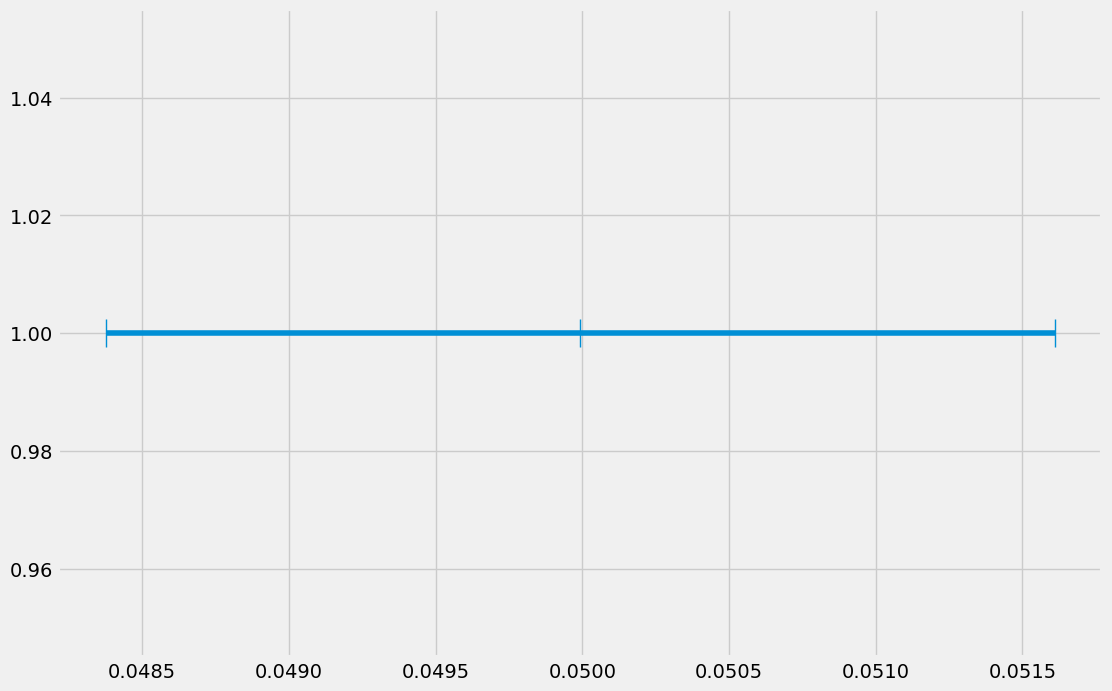

In [248]:
plt.figure(figsize=(12, 8))
plt.plot([df_res['control_confidence_interval_95.0_percent_lower'].values[0], df_res['control_mean'].values[0], df_res['control_confidence_interval_95.0_percent_upper'].values[0]], 
         [1,1,1], 
         linestyle='-', marker='|', ms=20)
# ax = df_res.plot(y=[0.055], x='control_mean')

In [340]:
def add_interval(ax, xdata, ydata, caps="  ", color='blue'):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color': line.get_color(),
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[-1], ydata[-1]), **anno_args)
    return (line,(a0,a1))

TypeError: add_interval() got multiple values for argument 'wtf'

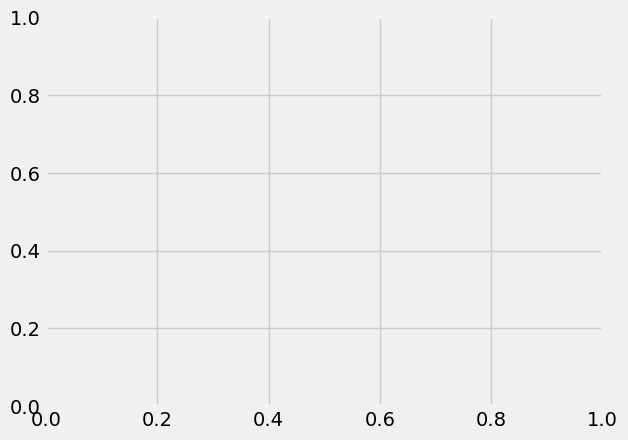

In [341]:
fig, ax = plt.subplots()
add_interval(ax, 
             [df_res['treatment_confidence_interval_95.0_percent_lower'].values[0], df_res['treatment_confidence_interval_95.0_percent_upper'].values[0]], 
             (1, 1), 
             "||", 
             color='green', 
             wtf='treatment')
add_interval(ax, 
             [df_res['control_confidence_interval_95.0_percent_lower'].values[0], df_res['control_confidence_interval_95.0_percent_upper'].values[0]], 
             (0.8, 0.8), 
             "||", 
             color='blue', 
             wtf='control')
plt.plot([df_res['control_mean'].values[0], df_res['treatment_mean'].values[0]], [0.8, 1], 'o', ms=10, color='black')
ax.annotate(np.round(df_res['control_mean'].values[0], 5), xy=(df_res['control_mean'].values[0], 0.85), ha='center', va='center', size=12)
ax.annotate(np.round(df_res['treatment_mean'].values[0], 5), xy=(df_res['treatment_mean'].values[0], 1.05), ha='center', va='center', size=12)
ax.annotate(np.round(df_res['treatment_confidence_interval_95.0_percent_upper'].values[0], 5), xy=(df_res['treatment_confidence_interval_95.0_percent_upper'].values[0], 0.9), ha='center', va='center', size=12)
ax.annotate(np.round(df_res['treatment_confidence_interval_95.0_percent_lower'].values[0], 5), xy=(df_res['treatment_confidence_interval_95.0_percent_lower'].values[0], 0.9), ha='center', va='center', size=12)

ax.annotate(np.round(df_res['control_confidence_interval_95.0_percent_upper'].values[0], 5), xy=(df_res['control_confidence_interval_95.0_percent_upper'].values[0], 0.7), ha='center', va='center', size=12)
ax.annotate(np.round(df_res['control_confidence_interval_95.0_percent_lower'].values[0], 5), xy=(df_res['control_confidence_interval_95.0_percent_lower'].values[0], 0.7), ha='center', va='center', size=12)

# x_min = np.min([df_res['treatment_confidence_interval_95.0_percent_lower'].values[0], df_res['control_confidence_interval_95.0_percent_lower'].values[0]])
# x_max = np.min([df_res['treatment_confidence_interval_95.0_percent_upper'].values[0], df_res['control_confidence_interval_95.0_percent_upper'].values[0]])

# x_max = x_max + 0.15*x_max
# x_min = x_min - 0.05*x_min

# plt.xlim((0.047, 0.06))
# plt.xlim((x_min, x_max))
plt.ylim((0.25, 1.25))

frame_ = plt.gca()
frame_.axes.yaxis.set_ticklabels([])

plt.title("Treatment vs Control results: p-value = {0}".format(np.round(df_res['p_value'].values[0], 10)), fontsize=16)
handles, _ = ax.get_legend_handles_labels()
plt.legend()

In [333]:
np.round(df_res['p_value'].values[0], 10)

1.8264e-05

In [286]:
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

0.04837550986519899

In [287]:
x_max

0.05161015321723829

In [290]:
x_max + 0.15*x_max

0.05935167619982403

In [291]:
x_min - 0.15*x_min

0.041119183385419145